In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [3]:
index = test_data['index']
test_data = test_data.drop('index', axis=1)

In [4]:
train_data= train_data.dropna(subset=['profile_image_url'])

In [5]:
# Convert boolean values into 0 and 1
train_data['default_profile'] = train_data['default_profile'].astype(int)
train_data['default_profile_image'] = train_data['default_profile_image'].astype(int)
train_data['geo_enabled'] = train_data['geo_enabled'].astype(int)
train_data['verified'] = train_data['verified'].astype(int)

test_data['default_profile'] = test_data['default_profile'].astype(int)
test_data['default_profile_image'] = test_data['default_profile_image'].astype(int)
test_data['geo_enabled'] = test_data['geo_enabled'].astype(int)
test_data['verified'] = test_data['verified'].astype(int)

In [6]:
# 1. Handle missing values in 'description'
train_data['description'].fillna('no description', inplace=True)
test_data['description'].fillna('no description', inplace=True)

In [7]:
# 2. Handle missing values in 'lang'
train_data['lang'].fillna('unknown', inplace=True)
test_data['lang'].fillna('unknown', inplace=True)

In [8]:
# 3. Handle 'profile_background_image_url'
train_data['has_background_image'] = np.where(train_data['profile_background_image_url'].isnull(), 0, 1)
train_data.drop('profile_background_image_url', axis=1, inplace=True)

test_data['has_background_image'] = np.where(test_data['profile_background_image_url'].isnull(), 0, 1)
test_data.drop('profile_background_image_url', axis=1, inplace=True)

In [9]:
# 5. Feature Engineering: Calculate engagement ratio (followers_count / friends_count)
# Avoid division by zero errors
train_data['engagement_ratio'] = train_data['followers_count'] / (train_data['friends_count'] + 1)
test_data['engagement_ratio'] = test_data['followers_count'] / (test_data['friends_count'] + 1)

In [10]:
# 6. Feature Engineering: Calculate tweet frequency (statuses_count / account_age_days)
train_data['tweet_frequency'] = train_data['statuses_count'] / train_data['account_age_days']
test_data['tweet_frequency'] = test_data['statuses_count'] / test_data['account_age_days']

In [11]:
# 7. Handle 'screen_name': Create length of screen_name feature
train_data['screen_name_length'] = train_data['screen_name'].apply(len)
test_data['screen_name_length'] = test_data['screen_name'].apply(len)

train_data['screen_name_has_numbers'] = train_data['screen_name'].apply(lambda x: int(any(char.isdigit() for char in str(x))))
test_data['screen_name_has_numbers'] = test_data['screen_name'].apply(lambda x: int(any(char.isdigit() for char in str(x))))

In [12]:
# Convert 'created_at' to datetime
train_data['created_at'] = pd.to_datetime(train_data['created_at'])

# Extract features from 'created_at'
train_data['creation_year'] = train_data['created_at'].dt.year
train_data['creation_month'] = train_data['created_at'].dt.month
train_data['creation_day_of_week'] = train_data['created_at'].dt.dayofweek
train_data['creation_hour'] = train_data['created_at'].dt.hour  # If time granularity matters

# Convert 'created_at' to datetime
test_data['created_at'] = pd.to_datetime(test_data['created_at'])

# Extract features from 'created_at'
test_data['creation_year'] = test_data['created_at'].dt.year
test_data['creation_month'] = test_data['created_at'].dt.month
test_data['creation_day_of_week'] = test_data['created_at'].dt.dayofweek
test_data['creation_hour'] = test_data['created_at'].dt.hour  # If time granularity matters

In [13]:
# Text length
train_data['description_length'] = train_data['description'].apply(len)

# Word count
train_data['description_word_count'] = train_data['description'].apply(lambda x: len(str(x).split()))

# Character count
train_data['description_character_count'] = train_data['description'].apply(lambda x: len(str(x)))

# Average word length
train_data['avg_word_length'] = train_data['description'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

# has_url
train_data['has_url'] = train_data['description'].apply(lambda x: int('http' in str(x)))

# Text length
test_data['description_length'] = test_data['description'].apply(len)

# Word count
test_data['description_word_count'] = test_data['description'].apply(lambda x: len(str(x).split()))

# Character count
test_data['description_character_count'] = test_data['description'].apply(lambda x: len(str(x)))

# Average word length
test_data['avg_word_length'] = test_data['description'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

# has_url
test_data['has_url'] = test_data['description'].apply(lambda x: int('http' in str(x)))

In [14]:
train_data['followers_to_friends_ratio'] = train_data['followers_count'] / (train_data['friends_count'] + 1)

test_data['followers_to_friends_ratio'] = test_data['followers_count'] / (test_data['friends_count'] + 1)

In [15]:
train_data['followers_favourites_interaction'] = train_data['followers_count'] * train_data['favourites_count']
train_data['friends_favourites_interaction'] = train_data['friends_count'] * train_data['favourites_count']

test_data['followers_favourites_interaction'] = test_data['followers_count'] * test_data['favourites_count']
test_data['friends_favourites_interaction'] = test_data['friends_count'] * test_data['favourites_count']

In [16]:
train_data['avg_favorites_per_day'] = train_data['favourites_count'] / (train_data['account_age_days'] + 1)
train_data['avg_followers_per_day'] = train_data['followers_count'] / (train_data['account_age_days'] + 1)
train_data['avg_statuses_per_day'] = train_data['statuses_count'] / (train_data['account_age_days'] + 1)

test_data['avg_favorites_per_day'] = test_data['favourites_count'] / (test_data['account_age_days'] + 1)
test_data['avg_followers_per_day'] = test_data['followers_count'] / (test_data['account_age_days'] + 1)
test_data['avg_statuses_per_day'] = test_data['statuses_count'] / (test_data['account_age_days'] + 1)

In [17]:
# has location
train_data['has_location'] = np.where(train_data['location'].isnull(), 0, 1)
test_data['has_location'] = np.where(test_data['location'].isnull(), 0, 1)

In [18]:
# Create a new binary column to flag default profile images
train_data['is_default_image'] = train_data['profile_image_url'].str.contains('default_profile_images').astype(int)

# Create a new binary column to flag default profile images
test_data['is_default_image'] = test_data['profile_image_url'].str.contains('default_profile_images').astype(int)

In [19]:
train_data['has_profile_image'] = train_data['profile_image_url'].notna().astype(int)

test_data['has_profile_image'] = test_data['profile_image_url'].notna().astype(int)

In [20]:
threshold = 200  # Define threshold for grouping
common_langs = train_data['lang'].value_counts()[train_data['lang'].value_counts() >= threshold].index

# Replace rare languages with 'other'
train_data['lang_grouped'] = train_data['lang'].apply(lambda x: x if x in common_langs else 'other')
test_data['lang_grouped'] = test_data['lang'].apply(lambda x: x if x in common_langs else 'other')

train_data['lang_encoded'] = train_data['lang_grouped'].astype('category').cat.codes
test_data['lang_encoded'] = test_data['lang_grouped'].astype('category').cat.codes

In [21]:
train_data.drop(['profile_image_url', 'created_at', 'description', 'location', 'lang', 'screen_name'], axis=1, inplace=True)

test_data.drop(['profile_image_url', 'created_at', 'description', 'location', 'lang', 'screen_name'], axis=1, inplace=True)

In [22]:
train_data.head(20)

,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,id,statuses_count,verified,average_tweets_per_day,account_age_days,target,has_background_image,engagement_ratio,tweet_frequency,screen_name_length,screen_name_has_numbers,creation_year,creation_month,creation_day_of_week,creation_hour,description_length,description_word_count,description_character_count,avg_word_length,has_url,followers_to_friends_ratio,followers_favourites_interaction,friends_favourites_interaction,avg_favorites_per_day,avg_followers_per_day,avg_statuses_per_day,has_location,is_default_image,has_profile_image,lang_grouped,lang_encoded
0,1,0,74,7,0,0,465096524,20,0,0.006,3138,1,1,7.000000,0.006373,8,1,2012,1,6,23,59,6,59,9.000000,1,7.000000,518,0,0.023574,0.002230,0.006371,1,0,1,en,3
1,0,0,50443,164,590,1,783105517673648132,6469,0,4.572,1415,0,1,0.277496,4.571731,8,0,2016,10,1,0,16,2,16,7.500000,0,0.277496,8272652,29761370,35.623588,0.115819,4.568503,1,0,1,other,9
2,0,0,9394,208,189,0,41970759,30296,0,7.378,4106,0,1,1.094737,7.378471,10,0,2009,5,5,4,24,4,24,5.250000,0,1.094737,1953952,1775466,2.287314,0.050645,7.376674,1,0,1,es,4
3,0,0,46,66180,1090,1,40607946,164957,0,40.116,4112,0,1,60.659945,40.116002,11,0,2009,5,6,4,147,28,147,4.285714,0,60.659945,3044280,50140,0.011184,16.090445,40.106248,1,0,1,en,3
4,1,0,1223,487,867,1,20983433,1752,0,0.417,4201,0,1,0.561060,0.417044,9,0,2009,2,0,13,55,9,55,5.222222,0,0.561060,595601,1060341,0.291052,0.115897,0.416944,1,0,1,en,3
5,0,0,7844,9308,1009,0,761884866,11425,0,3.907,2924,0,1,9.215842,3.907319,15,0,2012,8,3,16,152,18,152,7.333333,1,9.215842,73011952,7914596,2.681709,3.182222,3.905983,1,0,1,en,3
6,1,0,995,7,19,0,787658151776616448,1663,0,1.186,1402,0,0,0.350000,1.186163,12,0,2016,10,6,14,14,2,14,6.500000,0,0.350000,6965,18905,0.709195,0.004989,1.185317,1,0,1,unknown,11
7,0,0,36,51,0,0,227098845,330,0,0.093,3534,0,1,51.000000,0.093379,8,0,2010,12,2,22,80,14,80,4.785714,0,51.000000,1836,0,0.010184,0.014427,0.093352,1,0,1,pt,10
8,1,0,0,20,1,0,3748550069,1897,0,1.059,1792,1,1,10.000000,1.058594,10,0,2015,9,2,10,96,14,96,5.928571,1,10.000000,0,0,0.000000,0.011154,1.058003,1,0,1,en,3
9,1,0,100,538,1464,0,970509550909566976,4024,0,4.481,898,1,0,0.367235,4.481069,15,0,2018,3,0,4,137,24,137,4.750000,0,0.367235,53800,146400,0.111235,0.598443,4.476085,1,0,1,en,3


In [23]:
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['lang_grouped'], dtype='object')

In [24]:
# le = LabelEncoder()

# for col in categorical_columns:
#     train_data[col] = le.fit_transform(train_data[col])
#     test_data[col] = le.transform(test_data[col])

In [25]:
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('target') 

In [26]:
class Outlier_rem(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for outlier removal, return self
        return self
    
    def transform(self, X):
        # List of numerical columns to apply outlier removal
        numcol = numerical_columns
        
        # Iterate over each numerical column
        for col in numcol:
            # Calculate the interquartile range (IQR)
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            
            # Define lower and upper bounds for outliers
            lwr = q1 - (1.5 * iqr)
            upr = q3 + (1.5 * iqr)
            
            # Apply the lower bound: Replace values below the lower bound with the lower bound
            X[col] = X[col].apply(lambda x: lwr if x < lwr else x)
            
            # Apply the upper bound: Replace values above the upper bound with the upper bound
            X[col] = X[col].apply(lambda x: upr if x > upr else x)
        
        return X

# Define a transformer class to encode categorical features using LabelEncoder
class encoding(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for label encoding, return self
        return self
    
    def transform(self, X):
        le = LabelEncoder()
        # Iterate over the columns that need encoding 
        for col in categorical_columns:
            # Apply label encoding to the column
            X[col] = le.fit_transform(X[col])
        return X

# Define a transformer class to scale numerical features using StandardScaler
class Scaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for scaling, return self
        return self
    
    def transform(self, X):
        sc = StandardScaler()
        if 'target' in X.columns:
            for col in X.columns:
                if col != 'target':
                    X[col] = sc.fit_transform(X[[col]])
        else:
            # Scale all columns in the dataset
            for col in X.columns:
                X[col] = sc.fit_transform(X[[col]])
        return X

In [27]:
# Create a pipeline that chains together several preprocessing steps
pipeline = Pipeline([
    ('Outlier', Outlier_rem()),         # Remove outliers by capping them at 1.5 times the IQR
    ('encoding', encoding()),           # Encode categorical features using LabelEncoder
    ('scaling', Scaling())              # Scale numerical features using StandardScaler
])

In [28]:
train_data = pipeline.fit_transform(train_data)
test_data = pipeline.transform(test_data)

In [29]:
X = train_data.drop('target', axis=1)
y = train_data['target']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
classifier = LogisticRegression()

# 3. Fit the classifier to the preprocessed training data
classifier.fit(X_train, y_train)

# 4. Get the predicted probabilities for the test data
y_test_probs = classifier.predict_proba(X_test)[:, 1]  # Get the probability for the positive class (1)

# 5. Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

# 6. Calculate the Area Under the ROC Curve (AUC-ROC)
auc_roc = roc_auc_score(y_test, y_test_probs)

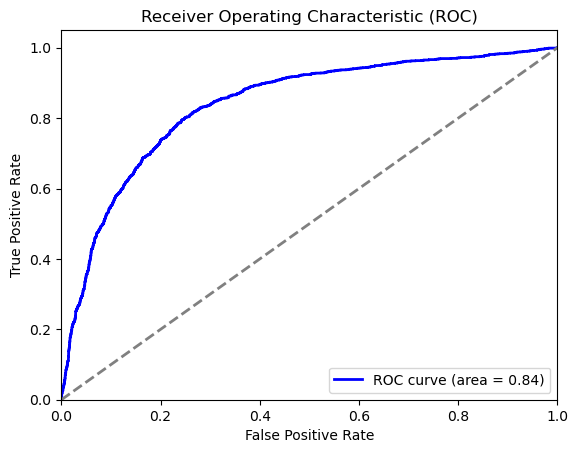

In [32]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [33]:
# 8. Print AUC-ROC score
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.8380122706035871


In [34]:
# # Define the Optuna objective function
# def objective(trial):
#     # Define hyperparameter search space for LightGBM
#     param = {
#         'objective': 'binary',
#         'metric': 'auc',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
#     }

#     # Create LightGBM datasets
#     dtrain = lgb.Dataset(X_train, label=y_train)
#     dvalid = lgb.Dataset(X_test, label=y_test, reference=dtrain)

#     # Train LightGBM model with early stopping
#     model = lgb.train(
#         param, dtrain, valid_sets=[dvalid]
#     )

#     # Predict the probabilities on the validation set (X_test)
#     y_pred = model.predict(X_test)

#     # Calculate the AUC-ROC score
#     auc = roc_auc_score(y_test, y_pred)
    
#     return auc  # Optuna maximizes this value

# # Create an Optuna study object and optimize
# study = optuna.create_study(direction='maximize')  # We want to maximize AUC
# study.optimize(objective, n_trials=100)  # Run 100 trials

# # Print the best hyperparameters found
# print("Best hyperparameters:", study.best_trial.params)

In [35]:
# # Train final model with the best parameters on the entire training dataset
# best_params = study.best_trial.params
# best_params['objective'] = 'binary'
# best_params['metric'] = 'auc'

# # Re-train the model using the best hyperparameters on the entire dataset
# final_model = lgb.train(best_params, lgb.Dataset(X, label=y))

In [36]:
# # Generate predictions on the test data (X_test) using the final model
# y_test_probs = final_model.predict(X_test)  # Ensure predictions are made on the same X_test

# # Calculate the AUC-ROC score on the test data
# auc_roc_test = roc_auc_score(y_test, y_test_probs)
# print("AUC-ROC Score on Test Data:", auc_roc_test)

# # Calculate the ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

In [37]:
# # Define the Optuna objective function
# def objective(trial):
#     # Define hyperparameter search space for CatBoost
#     param = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
#         'depth': trial.suggest_int('depth', 3, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
#         'random_strength': trial.suggest_uniform('random_strength', 1e-8, 10.0),
#         'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
#         'od_wait': trial.suggest_int('od_wait', 10, 50)
#     }

#     # Prepare CatBoost datasets
#     train_pool = Pool(X_train, label=y_train)
#     valid_pool = Pool(X_test, label=y_test)

#     # Train CatBoost model
#     model = CatBoostClassifier(
#         **param,
#         verbose=0,  # Suppress training logs
#         loss_function='Logloss',
#         eval_metric='AUC',
#         random_seed=42
#     )

#     model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)

#     # Predict probabilities for the validation set
#     y_pred = model.predict_proba(X_test)[:, 1]

#     # Calculate the AUC-ROC score
#     auc = roc_auc_score(y_test, y_pred)

#     return auc  # Optuna maximizes this value

# # Create an Optuna study object and optimize
# study = optuna.create_study(direction='maximize')  # We want to maximize AUC
# study.optimize(objective, n_trials=100)  # Run 100 trials

# # Print the best hyperparameters found
# print("Best hyperparameters:", study.best_trial.params)

In [49]:
# # Define the Optuna objective function with cross-validation
# def objective(trial):
#     # Define hyperparameter search space for CatBoost
#     param = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
#         'depth': trial.suggest_int('depth', 3, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
#         'random_strength': trial.suggest_uniform('random_strength', 1e-8, 10.0),
#         'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
#         'od_wait': trial.suggest_int('od_wait', 10, 50),
#         'loss_function': 'Logloss',  # Specify the loss function
#         'eval_metric': 'AUC',       # Specify the evaluation metric
#         'verbose': False  
#     }

#     # Prepare the dataset for CatBoost
#     train_pool = Pool(X_train, label=y_train)

#     # Perform cross-validation
#     cv_results = cv(
#         Pool(X, y),  # Full dataset
#         param,
#         fold_count=5,  # Number of folds
#         partition_random_seed=42,
#         early_stopping_rounds=50
#     )

#     # Extract the mean AUC from the cross-validation results
#     mean_auc = max(cv_results['test-AUC-mean'])

#     return mean_auc  # Optuna maximizes this value

# # Create an Optuna study object and optimize
# study = optuna.create_study(direction='maximize')  # We want to maximize AUC
# study.optimize(objective, n_trials=100)  # Run 100 trials

# # Print the best hyperparameters found
# print("Best hyperparameters:", study.best_trial.params)

In [40]:
# Train final model with the best parameters on the entire dataset
best_params = study.best_trial.params

# Add necessary fixed parameters
best_params['loss_function'] = 'Logloss'  # For binary classification
best_params['eval_metric'] = 'AUC'
best_params['random_seed'] = 42  # Ensure reproducibility

# Re-train the model using the best hyperparameters on the entire dataset
final_pool = Pool(X, label=y)

final_model = CatBoostClassifier(
    **best_params,
    verbose=100  # Display progress during training
)

# Train the final model
final_model.fit(final_pool)

0:	total: 10.4ms	remaining: 6.22s
100:	total: 800ms	remaining: 3.94s
200:	total: 1.57s	remaining: 3.1s
300:	total: 2.34s	remaining: 2.31s
400:	total: 3.12s	remaining: 1.53s
500:	total: 3.88s	remaining: 751ms
597:	total: 4.65s	remaining: 0us


AUC-ROC Score on Test Data: 0.9912477691088365


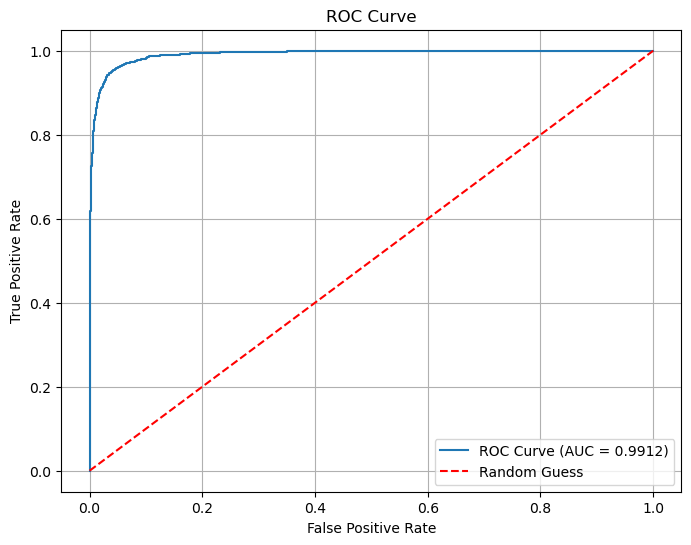

In [41]:
# Generate predictions on the test data (X_test) using the final model
y_test_probs = final_model.predict_proba(X_test)[:, 1]  # Use predict_proba for probability predictions

# Calculate the AUC-ROC score on the test data
auc_roc_test = roc_auc_score(y_test, y_test_probs)
print("AUC-ROC Score on Test Data:", auc_roc_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_roc_test:.4f})")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

In [45]:
y_test_probs = final_model.predict(test_data)  # Probabilities for class 1 (positive class)

submission = pd.DataFrame({'index': index, 'target': y_test_probs})
submission.to_csv('psubmission_cat.csv', index=False)

In [46]:
# Define the Optuna objective function
def objective(trial):
    # Define hyperparameter search space for LightGBM
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_bin': trial.suggest_int('max_bin', 64, 512),
    }

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]
        
        # Create LightGBM datasets
        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dvalid = lgb.Dataset(X_valid_cv, label=y_valid_cv, reference=dtrain)

        # Train LightGBM model with early stopping and pruning
        model = lgb.train(
            param, dtrain, valid_sets=[dvalid]
        )
        
        # Predict and calculate AUC for the validation fold
        y_pred = model.predict(X_valid_cv)
        auc = roc_auc_score(y_valid_cv, y_pred)
        auc_scores.append(auc)
    
    # Return the mean AUC across folds
    return np.mean(auc_scores)

# Create an Optuna study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_trial.params)

[I 2024-11-11 11:58:56,264] A new study created in memory with name: no-name-0219d6ec-2580-4326-b1ef-f092b18dc4e5
[I 2024-11-11 11:58:58,233] Trial 0 finished with value: 0.9090087137562544 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.6875593894232288e-06, 'lambda_l2': 1.631898063876471e-05, 'num_leaves': 37, 'max_depth': 7, 'feature_fraction': 0.8816183490847009, 'bagging_fraction': 0.5257915374004266, 'bagging_freq': 6, 'min_child_samples': 57, 'min_split_gain': 0.018573245489112346, 'learning_rate': 0.00018969320877466287, 'max_bin': 81}. Best is trial 0 with value: 0.9090087137562544.
[I 2024-11-11 11:59:00,760] Trial 1 finished with value: 0.9141102342047815 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.5230701066908934e-07, 'lambda_l2': 0.10769971717435216, 'num_leaves': 90, 'max_depth': 8, 'feature_fraction': 0.9790297570575747, 'bagging_fraction': 0.4794366229041681, 'bagging_freq': 2, 'min_child_samples': 99, 'min_split_gain': 1.5640744613559806e-06, 'le

Best hyperparameters: {'boosting_type': 'gbdt', 'lambda_l1': 5.864856461171299e-07, 'lambda_l2': 6.887956509254185e-05, 'num_leaves': 67, 'max_depth': 11, 'feature_fraction': 0.8126794745168582, 'bagging_fraction': 0.9730096106095549, 'bagging_freq': 2, 'min_child_samples': 72, 'min_split_gain': 1.13139268191081e-05, 'learning_rate': 0.083431202634917, 'max_bin': 179}


In [47]:
# Train final model with the best parameters on the entire dataset
best_params = study.best_trial.params
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'

final_model_lgb = lgb.train(best_params, lgb.Dataset(X, label=y))

# Generate predictions on the test data (X_test) using the final model
y_test_probs = final_model_lgb.predict(X_test)

# Calculate the AUC-ROC score on the test data
auc_roc_test = roc_auc_score(y_test, y_test_probs)
print("AUC-ROC Score on Test Data:", auc_roc_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

AUC-ROC Score on Test Data: 0.9772104616362721


In [48]:
y_test_probs = final_model_lgb.predict(test_data)  # Probabilities for class 1 (positive class)

submission = pd.DataFrame({'index': index, 'target': y_test_probs})
submission.to_csv('psubmission_lgb.csv', index=False)